SARIMA models using Statsmodels in Python

## The Difference Between ARIMA and SARIMA Models

The big difference between an ARIMA model and a SARIMA model is the addition of seasonal error components to the model. Remember that the purpose of an ARIMA model is to make the time-series that you are working with act like a stationary series. This is important because if it isn’t stationary, you can get biased estimates of the coefficients.

There is no difference with a SARIMA model. We are still trying to get the series to behave in a stationary way, so that our model gets estimated correctly. I want to emphasize that you could get away with a regular old ARIMA model for this if you satisfy a couple of conditions.

1. You have enough data to estimate a large number of coefficients.
2. You are willing to assume a really complicated error structure.

Generally, I am not willing to entertain either of those assumptions, and that’s why we have a SARIMA model. Seasonality can come in two basic varieties, multiplicative and additive. By default statsmodels works with a multiplicative seasonal components. For our model it really won’t matter.

In [16]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline

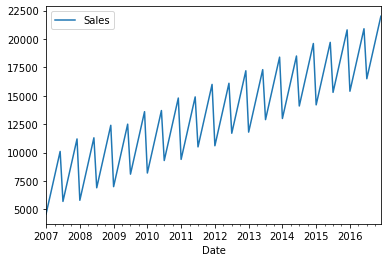

In [2]:
sales = pd.read_csv('salesdata.csv')
sales.index = pd.to_datetime(sales["Date"])
sales.plot()

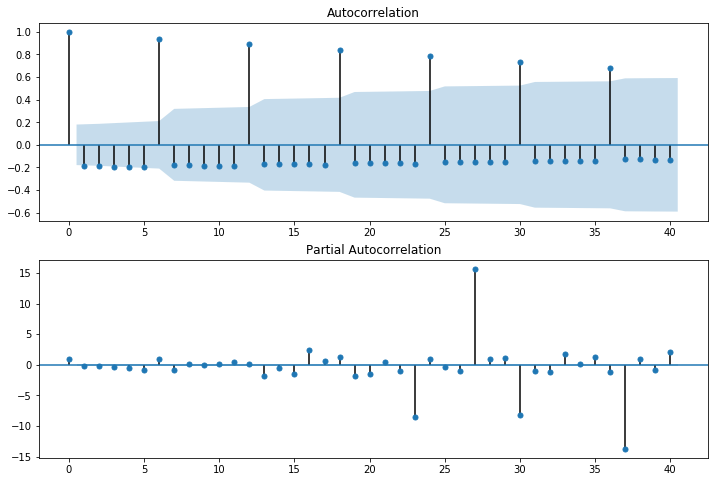

In [4]:
ds = sales['Sales'].diff().dropna()
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ds, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ds, lags=40, ax=ax2)

## MODEL

In [8]:
model=sm.tsa.statespace.SARIMAX(endog=sales['Sales'],order=(0,1,0),seasonal_order=(0,0,1,6),trend='c',enforce_invertibility=False)
results=model.fit()
print(results.summary())

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:160: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


                                 Statespace Model Results                                
Dep. Variable:                             Sales   No. Observations:                  120
Model:             SARIMAX(0, 1, 0)x(0, 0, 1, 6)   Log Likelihood               -3141.949
Date:                           Fri, 22 Nov 2019   AIC                           6289.897
Time:                                   15:45:30   BIC                           6298.235
Sample:                               01-01-2007   HQIC                          6293.283
                                    - 12-01-2016                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    146.2185        nan        nan        nan         nan         nan
ma.S.L6    -5.797e+14         -0        inf

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


In [11]:
print(sales['Sales'].diff().diff(12).dropna())

Date
2008-02-01    0.0
2008-03-01    0.0
2008-04-01    0.0
2008-05-01    0.0
2008-06-01    0.0
             ... 
2016-08-01    0.0
2016-09-01    0.0
2016-10-01    0.0
2016-11-01    0.0
2016-12-01    0.0
Name: Sales, Length: 107, dtype: float64


In [14]:
print(sales['Sales'].diff(12).dropna())

Date
2008-01-01    1200.0
2008-02-01    1200.0
2008-03-01    1200.0
2008-04-01    1200.0
2008-05-01    1200.0
               ...  
2016-08-01    1200.0
2016-09-01    1200.0
2016-10-01    1200.0
2016-11-01    1200.0
2016-12-01    1200.0
Name: Sales, Length: 108, dtype: float64


In [22]:
class StationarityTests:
    def __init__(self, significance=.05):
        self.SignificanceLevel = significance
        self.pValue = None
        self.isStationary = None
    
    def ADF_Stationarity_Test(self, timeseries, printResults = True):
        #Dickey-Fuller test:
        adfTest = sm.tsa.stattools.adfuller(timeseries, autolag='AIC')
        
        
        self.pValue = adfTest[1]
        
        if (self.pValue<self.SignificanceLevel):
            self.isStationary = True
        else:
            self.isStationary = False
        
        if printResults:
            dfResults = pd.Series(adfTest[0:4], index=['ADF Test Statistic','P-Value','# Lags Used','# Observations Used'])
            #Add Critical Values
            for key,value in adfTest[4].items():
                dfResults['Critical Value (%s)'%key] = value
            print('Augmented Dickey-Fuller Test Results:')
            print(dfResults)

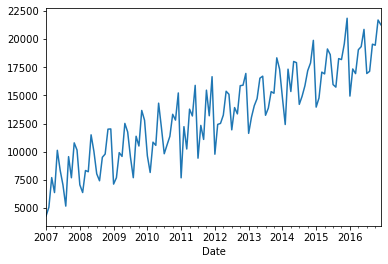

In [19]:
np.random.seed(5968)
noise=[np.random.normal(scale=500)]

for i in range(len(sales)-1):
    noise.append(np.random.normal(scale=500)+noise[i]*(-0.85))
sales['Sales2']=sales['Sales']+noise
sales['Sales2'].plot()

(-4.455060575759193, 0.00023686499712736295, 13, 93, {'1%': -3.502704609582561, '5%': -2.8931578098779522, '10%': -2.583636712914788}, 1477.0429266000792)
Augmented Dickey-Fuller Test Results:
ADF Test Statistic      -4.455061
P-Value                  0.000237
# Lags Used             13.000000
# Observations Used     93.000000
Critical Value (1%)     -3.502705
Critical Value (5%)     -2.893158
Critical Value (10%)    -2.583637
dtype: float64
Is the time series stationary? True


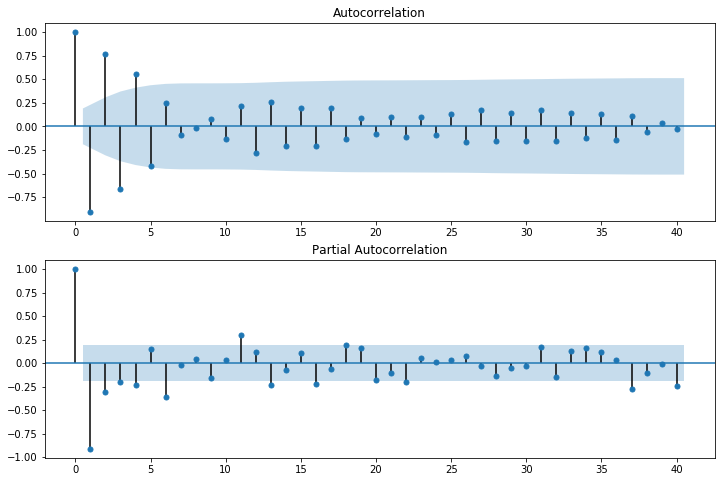

In [23]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(sales['Sales2'].diff().diff(12).dropna(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(sales['Sales2'].diff().diff(12).dropna(), lags=40, ax=ax2)

print(sm.tsa.stattools.adfuller(sales['Sales2'].diff().diff(12).dropna()))
sTest = StationarityTests()
sTest.ADF_Stationarity_Test(sales['Sales2'].diff().diff(12).dropna(), printResults = True)
print("Is the time series stationary? {0}".format(sTest.isStationary))

In [25]:
model=sm.tsa.statespace.SARIMAX(endog=sales['Sales2'],order=(1,1,0),seasonal_order=(0,1,0,12),trend='c',enforce_invertibility=False)
results=model.fit()
print(results.summary())

                                 Statespace Model Results                                 
Dep. Variable:                             Sales2   No. Observations:                  120
Model:             SARIMAX(1, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -886.247
Date:                            Fri, 22 Nov 2019   AIC                           1778.494
Time:                                    15:55:36   BIC                           1786.512
Sample:                                01-01-2007   HQIC                          1781.744
                                     - 12-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    -50.4501     85.697     -0.589      0.556    -218.414     117.514
ar.L1         -0.8990      0.037   

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:160: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


In [27]:
model2=sm.tsa.statespace.SARIMAX(endog=sales['Sales2'],order=(1,1,0),seasonal_order=(0,1,1,12),trend='c',enforce_invertibility=False)
results2=model2.fit()
print(results2.summary())

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:160: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


                                 Statespace Model Results                                 
Dep. Variable:                             Sales2   No. Observations:                  120
Model:             SARIMAX(1, 1, 0)x(0, 1, 1, 12)   Log Likelihood                -871.261
Date:                            Fri, 22 Nov 2019   AIC                           1750.523
Time:                                    16:00:56   BIC                           1761.214
Sample:                                01-01-2007   HQIC                          1754.857
                                     - 12-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    -18.8852     28.424     -0.664      0.506     -74.594      36.824
ar.L1         -0.9217      0.033   